In [11]:
import atlite
import pandas as pd
from bc_power import utils
import geopandas as gpd
import xarray as xr 
import matplotlib.pyplot as plt

In [ ]:
def create_cutout(cutout_file,bounds,dx=0.25,dy=0.25,time_horizon=slice('2021-01-01', '2021-12-31'), module="era5"):
    '''
    This function creates a cutout from Atlite and saves it to the cutout_file (path + filename).
    '''
    cutout = atlite.Cutout(path=cutout_file,
                        module=module,
                        x=slice(bounds['west_lon'] - dx, bounds['east_lon'] + dx),
                        y=slice(bounds['south_lat'] - dy,bounds['north_lat'] + dy ),
                        dx=dx,
                        dy=dy,
                        time=time_horizon)

    cutout.prepare()

In [ ]:
# call create_cutout

In [8]:
config_file = r"/mnt/c/Users/pmcw9/Delta-E/PICS/PyPSA_BC/config/config.yaml"
cfg = utils.load_config(config_file)
cutout = atlite.Cutout(path=cfg["cutout"]["file"])

In [18]:
# Used for indexing later
cap_factors = cutout.wind(turbine='Vestas_V112_3MW', capacity_factor=True)

# This code calculates the cells/grids for where generation exists
# Cells of the cutout
cells = cutout.grid 

#site: location of the termines with latitudes and longitudes specified
sites = gpd.GeoDataFrame([['Abbostsford', -122.310817, 49.045174, 10], # name, lon, lat, capacity
                          ['Vancouver', -123.134549, 49.287283, 20]],
                         columns=['name', 'lon', 'lat', 'capacity']
                         ).set_index('name')

# Finds cutout cells nearest to (lat,lon) of each site 
# (x,y) of cells/grids are the center points by default and correspong to (lat,lon) of the cells.
nearest = cutout.data.sel(
    {'x': sites.lon.values, 'y': sites.lat.values}, 'nearest').coords

# Add new columns for the grid (x,y) where each generator falls.
sites['x'] = nearest.get('x').values
sites['y'] = nearest.get('y').values

# Performs an inner join on the (x,y) values
cells_generation = sites.merge(
    cells, how='inner').rename(pd.Series(sites.index))

# Layout indicates the installed capacity and grid location of installed capacity
layout = xr.DataArray(cells_generation.set_index(['y', 'x']).capacity.unstack())\
                    .reindex_like(cap_factors).rename('Installed Capacity [MW]')

# Finally generate the power produced at these sites
# Returns the power generation of the generators for each location
# The data is returned as an xarray with shape of (timesteps, generators)
power_generation = cutout.wind(turbine = "Vestas_V112_3MW",
                                layout = layout,
                                shapes = cells_generation.geometry,
                                per_unit = False) # currently using per-unit

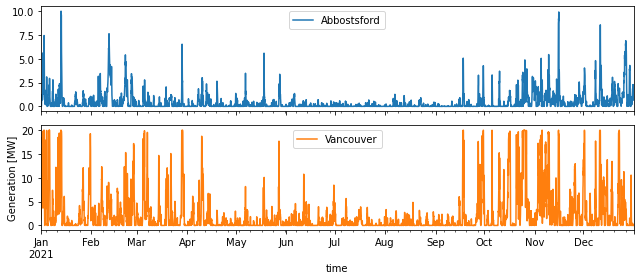

In [19]:
# Plotting of the power generation
fig, axes = plt.subplots(len(sites), sharex=True, figsize=(9, 4))
power_generation.to_pandas().plot(subplots=True, ax=axes)
axes[0].set_xlabel('date')
axes[1].set_ylabel('Generation [MW]')
fig.tight_layout()